In [1]:
import glob
from osgeo import gdal, ogr, osr
import geopandas as gpd
import pandas as pd
import sys, os
sys.path.append('/home/pmontesa/code/dgtools')
sys.path.append('/home/pmontesa/code/pygeotools')
import pygeotools 

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib

# This is a private repo
from dgtools.lib import dglib

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import contextily as ctx

ImportError: cannot import name 'wktf' from 'shapely' (/panfs/ccds02/app/modules/jupyter/ilab/pytorch-kernel/lib/python3.9/site-packages/shapely/__init__.py)

# Here is all the SRLite input from test sites

In [ ]:
maindir_toa = '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input'
dir_list_toa = glob.glob(maindir_toa +  '/*/')
dir_list_toa

In [ ]:
maindir_sr = '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all'
dir_list_sr = glob.glob(maindir_sr +  '/*/')
dir_list_sr

#### Make a dataframe of metadata 

In [ ]:
# This function was pulled in from vhrlib.py

#pd.concat([vhrlib.make_vhr_xml_dataframe(f) for f in f_list])
#pd.concat([vhrlib.make_vhr_xml_dataframe(xml_fn) for xml_fn in f_list[0:3]])

### Make a dictionary of VHR metadata
Use dgtools to pull out metadata for list of TOAs in a dir

In [ ]:
indir = dir_list_toa[1]
id_list = dglib.dir_ids(indir)
print(id_list[0])
d_list = [dglib.get_id_dict(indir, id) for id in id_list]

In [128]:
d_list[0]

{'id': '1020010004D37600',
 'sensor': 'WV01',
 'date': datetime.datetime(2008, 10, 11, 15, 31, 13, 772292),
 'alt': 496.0,
 'az': 104.4,
 'el': 74.6,
 'sunaz': 164.4,
 'sunel': 36.5,
 'gsd': 0.53,
 'scandir': 'Reverse',
 'tdi': 16,
 'offnadir': 14.3,
 'intrack': -1.0,
 'crosstrack': 14.2,
 'cloudcover': 0.0,
 'geom': <osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x14fc42144690> >,
 'geom_poly': <POLYGON ((-68.828 45.263, -68.587 45.259, -68.587 45.095, -68.828 45.096, -...>,
 'stereopair': None}

In [7]:
# from itertools import groupby

# print([{"name": key, "data": [(g['id'], g['gsd']) for g in group]} 
#        for key, group in groupby(d_list, lambda x: x['sensor'])])

# Build a geodataframe for each dir with vhr metadata

In [126]:
# Build a vhr xml dataframe for everything
for indir in dir_list_toa:
    TARGET = os.path.basename(indir.rstrip('/'))
    id_list = dglib.dir_ids(indir)
    d_list = [dglib.get_id_dict(indir, id) for id in id_list]
    
    # Get TOA gdf
    TARGET_DIR_TOA = [indir for indir in dir_list_toa if TARGET in indir][0]
    # get footprints gdf from a target dir
    TARGET_DIR_TOA = TARGET_DIR_TOA.rstrip('/')
    print(TARGET_DIR_TOA)
    f_list_toa =glob.glob(f'{TARGET_DIR_TOA}/*toa.tif')
    f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_toa]
    footprint_gdf_toa = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
    footprint_gdf_toa['type'] = 'TOA'
    footprint_gdf_toa['name'] = footprint_gdf_toa['file'].str.split('-toa', expand=True)[0]
    
    # Get SR gdf
    TARGET_DIR_SR = [indir for indir in dir_list_sr if TARGET in indir][0]
    # get footprints gdf from a target dir
    TARGET_DIR_SR = TARGET_DIR_SR.rstrip('/')
    print(TARGET_DIR_SR)
    f_list_sr =glob.glob(f'{TARGET_DIR_SR}/*sr*.tif')
    f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_sr]
    footprint_gdf_sr = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
    footprint_gdf_sr['type'] = 'SR'
    footprint_gdf_sr['name'] = footprint_gdf_sr['file'].str.split('-sr', expand=True)[0]
    
    # Outer join lets you see which TOAs dont have corresponding SR
    footprint_gdf = pd.merge(footprint_gdf_sr, footprint_gdf_toa[['file', 'name', 'path']], how='outer', left_on = 'name', right_on = 'name', copy=False)

    # Some TOAs might not produce SR - find them.
    footprint_gdf_TOA_no_SR = footprint_gdf[footprint_gdf.path_x.isnull()]
    num_missing_SR = footprint_gdf_TOA_no_SR.shape[0]
    footprint_gdf = footprint_gdf[~footprint_gdf.path_x.isnull()]

    print( f"# TOAs missing SR images: {num_missing_SR}")
    footprint_gdf['catid'] = footprint_gdf['name'].str.split('_', expand=True)[3]
    footprint_gdf['sensor'] = footprint_gdf['file_x'].str.split('_', expand=True)[0]
    footprint_gdf['year'] = footprint_gdf['file_x'].str.split('_', expand=True)[1].str[0:4].astype(int)
    footprint_gdf['month'] = footprint_gdf['file_x'].str.split('_', expand=True)[1].str[4:6].astype(int)
    print( f"# SR images: {footprint_gdf[footprint_gdf['type'] == 'SR'].shape[0]}")
    
    # Get list of dictionaries of metadata for each VHR image
    d_list = [dglib.get_id_dict(TARGET_DIR_TOA, id) for id in id_list ]
    vhr_df = pd.DataFrame(d_list)
    vhr_gdf = gpd.GeoDataFrame(vhr_df, geometry='geom_poly')
    
     #Prefer to join VHR df to my footprints
    footprint_gdf_tmp = pd.merge(footprint_gdf, vhr_df[['id', 'el', 'az', 'sunel', 'sunaz']], how='left', left_on = 'catid', right_on = 'id', copy=False)

    num_null = footprint_gdf_tmp[footprint_gdf_tmp.catid.isnull()].shape[0]
    print(f'# of footprints with no metadata from dglib: {num_null}')
    
    polar_plot_fig = vhrlib.MAKE_DIR_POLAR_PLOT(d_list, TARGET_DIR_TOA, title='')
    
    footprint_gdf_tmp.to_file(f'/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_srlite_{TARGET}_igarss_.gpkg', driver='GPKG')

AttributeError: 'NoneType' object has no attribute 'text'

### Plot view geom of acquisition
reference:  
https://github.com/dshean/dgtools/blob/master/notebooks/dg_pair_geom_eph_analysis.ipynb

In [134]:
# import importlib
# importlib.reload(dgtools)

In [130]:
if True:
    
    exclude_list = ['Yukon_Delta']

    for indir in dir_list_toa:

        indir = indir.rstrip('/')
        print(os.path.basename(indir))

        if os.path.basename(indir) not in exclude_list:  

            id_list = dglib.dir_ids(indir)
            print(len(id_list))

            # Get list of dictionaries of metadata for each VHR image
            d_list = [dglib.get_id_dict(indir, id) for id in id_list if not str(id).startswith('101')]

            returned_stuff = MAKE_DIR_POLAR_PLOT(d_list, indir)

RailroadValley
74


AttributeError: 'NoneType' object has no attribute 'text'

Acquisition geometry should be something that helps explain poor SRLite results. We can add to the assessment tools batch polar plotting to visualize the variation in acquisitions within a batch

In [11]:
TARGET = 'Alaska'

In [12]:

# [indir for indir in dir_list_toa if TARGET in indir][0]

### Build footprint gdf for TARGET

##### TOA

In [13]:
%%time 
TARGET_DIR_TOA = [indir for indir in dir_list_toa if TARGET in indir][0]

# Get footprints gdf from a target dir
TARGET_DIR_TOA = TARGET_DIR_TOA.rstrip('/')
print(TARGET_DIR_TOA)
f_list_toa =glob.glob(f'{TARGET_DIR_TOA}/*toa.tif')
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_toa]
footprint_gdf_toa = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_toa['type'] = 'TOA'
footprint_gdf_toa['name'] = footprint_gdf_toa['file'].str.split('-toa', expand=True)[0]

footprint_gdf_toa.info()

/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska
Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 176 entries, 0 to 175
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            176 non-null    object  
 1   geometry        176 non-null    geometry
 2   footprint_name  0 non-null      object  
 3   path            176 non-null    object  
 4   area_km2        176 non-null    float64 
 5   area_ha         176 non-null    float64 
 6   type            176 non-null    object  
 7   name            176 non-null    object  
dtypes: float64(2), geometry(1), object(5)
memory usage: 12.4+ KB
CPU times: user 2.31 s, sys: 299 ms, total: 2.61 s
Wall time: 11.1 s


##### SR

In [14]:
TARGET_DIR_SR = [indir for indir in dir_list_sr if TARGET in indir][0]

# Get footprints gdf from a target dir
TARGET_DIR_SR = TARGET_DIR_SR.rstrip('/')
print(TARGET_DIR_SR)
f_list_sr =glob.glob(f'{TARGET_DIR_SR}/*sr*.tif')
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_sr]
footprint_gdf_sr = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_sr['type'] = 'SR'
footprint_gdf_sr['name'] = footprint_gdf_sr['file'].str.split('-sr', expand=True)[0]

footprint_gdf_sr.info()

/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska
Building GDF from list...
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 172 entries, 0 to 171
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   file            172 non-null    object  
 1   geometry        172 non-null    geometry
 2   footprint_name  0 non-null      object  
 3   path            172 non-null    object  
 4   area_km2        172 non-null    float64 
 5   area_ha         172 non-null    float64 
 6   type            172 non-null    object  
 7   name            172 non-null    object  
dtypes: float64(2), geometry(1), object(5)
memory usage: 12.1+ KB


### Join gdfs

In [15]:
# Outer join lets you see which TOAs dont have corresponding SR
footprint_gdf = pd.merge(footprint_gdf_sr, footprint_gdf_toa[['file', 'name', 'path']], how='outer', left_on = 'name', right_on = 'name', copy=False)

# Some TOAs might not produce SR - find them.
footprint_gdf_TOA_no_SR = footprint_gdf[footprint_gdf.path_x.isnull()]
num_missing_SR = footprint_gdf_TOA_no_SR.shape[0]
footprint_gdf = footprint_gdf[~footprint_gdf.path_x.isnull()]

print( f"# TOAs missing SR images: {num_missing_SR}")

# TOAs missing SR images: 4


In [16]:
footprint_gdf.columns.to_list()

['file_x',
 'geometry',
 'footprint_name',
 'path_x',
 'area_km2',
 'area_ha',
 'type',
 'name',
 'file_y',
 'path_y']

In [17]:
footprint_gdf['catid'] = footprint_gdf['name'].str.split('_', expand=True)[3]
footprint_gdf['sensor'] = footprint_gdf['file_x'].str.split('_', expand=True)[0]
footprint_gdf['year'] = footprint_gdf['file_x'].str.split('_', expand=True)[1].str[0:4].astype(int)
footprint_gdf['month'] = footprint_gdf['file_x'].str.split('_', expand=True)[1].str[4:6].astype(int)


#footprint_gdf[footprint_gdf.type == 'SR'].head()
#print( f"# TOA images: {footprint_gdf[footprint_gdf['type']  == 'TOA'].shape[0]}")
print( f"# SR images: {footprint_gdf[footprint_gdf['type'] == 'SR'].shape[0]}")

# SR images: 172


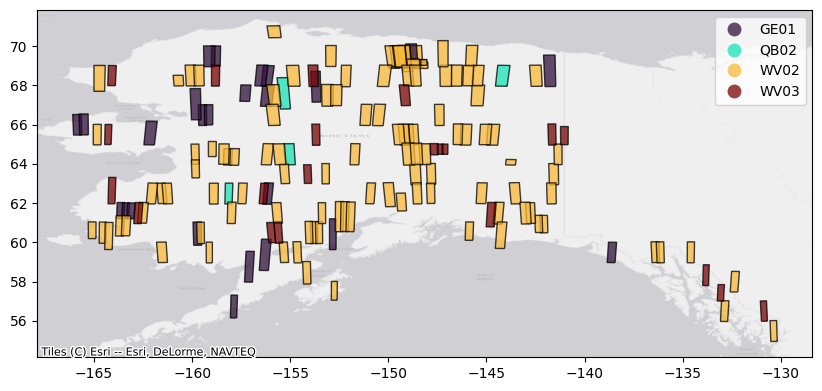

In [17]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
#colors = {'TOA':'tab:red', 'SR':'tab:green'}
#colors = {'QB02':'tab:pink', 'GE01':'tab:green', 'WV01':'tab:blue', 'WV02':'tab:red', 'WV03':'tab:purple'}

# Plot type
#ax = footprint_gdf.plot(ax=ax, alpha=0.5, ec='k', column='sensor', label='file', categorical=True, legend=True, cmap='viridis')

# Plot sensor of SR
ax1 = footprint_gdf[footprint_gdf['type']  == 'SR'].plot(ax=ax1, alpha=0.75, ec='k', column='sensor', categorical=True, legend=True, cmap='turbo')

#ax = target_footprint_gdf.boundary.plot(ax=ax, color='red')

#ax.legend(loc="upper left")
ax1 = ctx.add_basemap(ax1, crs=4326, 
    #source = ctx.providers.Gaode.Satellite
    #source = ctx.providers.Esri.WorldShadedRelief
    source = ctx.providers.Esri.WorldGrayCanvas
    #source = ctx.providers.Esri.NatGeoWorldMap
    #source = ctx.providers.Esri.WorldImagery
    #source = ctx.providers.Esri.DeLorme
)


# Use dglib to get VHR metadata

In [18]:
id_list = dglib.dir_ids(TARGET_DIR_TOA)
TARGET_DIR_TOA

'/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska'

<Axes: >

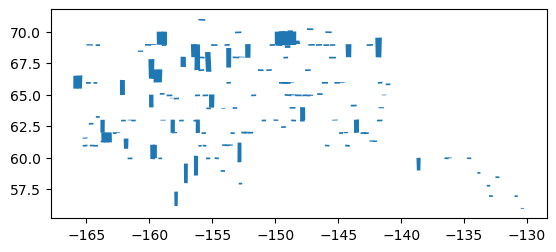

In [19]:
# Get list of dictionaries of metadata for each VHR image
#d_list = [dglib.get_id_dict(TARGET_DIR_TOA, id) for id in id_list if not str(id).startswith('101')] # 101 is QB01
d_list = [dglib.get_id_dict(TARGET_DIR_TOA, id) for id in id_list ]
vhr_df = pd.DataFrame(d_list)
vhr_gdf = gpd.GeoDataFrame(vhr_df, geometry='geom_poly')
vhr_gdf.plot()

In [111]:
import importlib
importlib.reload(vhrlib)

<module 'vhrlib' from '/panfs/ccds02/home/pmontesa/code/geoscitools/vhrlib.py'>

### Join metadata to footprints

In [112]:
# Prefer to join VHR df to my footprints
footprint_gdf_tmp = pd.merge(footprint_gdf, vhr_df[['id', 'el', 'az', 'sunel', 'sunaz']], how='left', left_on = 'catid', right_on = 'id', copy=False)

num_null = footprint_gdf_tmp[footprint_gdf_tmp.catid.isnull()].shape[0]
print(f'# of footprints with no metadata from dglib: {num_null}')
footprint_gdf_tmp.columns

# of footprints with no metadata from dglib: 0


Index(['file_x', 'geometry', 'footprint_name', 'path_x', 'area_km2', 'area_ha',
       'type', 'name', 'file_y', 'path_y', 'catid', 'sensor', 'year', 'month',
       'id', 'el', 'az', 'sunel', 'sunaz'],
      dtype='object')

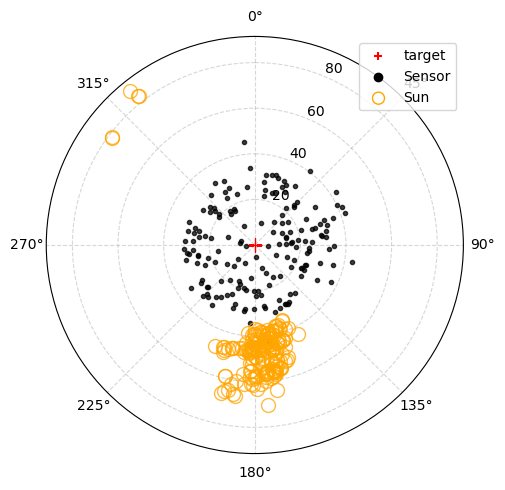

In [113]:
# Make polar plot of SSG
polar_plot_fig = vhrlib.MAKE_DIR_POLAR_PLOT(d_list, TARGET_DIR_TOA, title='')
polar_plot_fig.savefig('/explore/nobackup/people/pmontesa/userfs02/projects/srlite/plots/igarss_srlite_alaska_polarplot.png', dpi=300, bbox_inches='tight')

### Save the Alaska IGARSS VHR dataframe

In [96]:
vhr_df.to_csv('/explore/nobackup/people/pmontesa/srlite/srlite_alaska_igarss.csv')
footprint_gdf_tmp.to_file('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_srlite_alaska_igarss.gpkg', driver='GPKG')

# Build geodataframe of footprints and map from huge Alaska request 

In [43]:
TARGET = 'Alaska_ahri_20221004'
TARGET_DIR_TOA = f'/explore/nobackup/projects/ilab/data/srlite/toa/{TARGET}'

# Get footprints gdf from a target dir
TARGET_DIR_TOA = TARGET_DIR_TOA.rstrip('/')
print(TARGET_DIR_TOA)

f_list_toa =glob.glob(f'{TARGET_DIR_TOA}/*/*/5-toas/*toa.tif')
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_toa]
footprint_gdf_toa = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_toa['type'] = 'TOA'
footprint_gdf_toa['name'] = footprint_gdf_toa['file'].str.split('-toa', expand=True)[0]
footprint_gdf_toa['catid'] = footprint_gdf_toa['name'].str.split('_', expand=True)[3]

footprint_gdf_toa['sensor'] = footprint_gdf_toa['file'].str.split('_', expand=True)[0]
footprint_gdf_toa['year'] = footprint_gdf_toa['file'].str.split('_', expand=True)[1].str[0:4].astype(int)
footprint_gdf_toa['month'] = footprint_gdf_toa['file'].str.split('_', expand=True)[1].str[4:6].astype(int)

# Drop dups from 'repair'
footprint_gdf_toa.drop_duplicates(subset='file', keep='last', inplace=True)

print( f"# {TARGET} images: {footprint_gdf_toa.shape[0]}")

footprint_gdf_toa.head()

/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004
Building GDF from list...
# Alaska_ahri_20221004 images: 2188


,geometry,footprint_name,path,file,area_km2,area_ha,type,name,catid,sensor,year,month
59,"POLYGON ((-130.92342 55.29930, -130.97517 56.3...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV03_20180731_M1BS_1040010040468E00-toa.tif,2015.868608,201586.8608,TOA,WV03_20180731_M1BS_1040010040468E00,1040010040468E00,WV03,2018,7
60,"POLYGON ((-130.31838 55.96727, -130.35538 57.0...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV02_20180723_M1BS_1030010082B2E500-toa.tif,2497.594824,249759.4824,TOA,WV02_20180723_M1BS_1030010082B2E500,1030010082B2E500,WV02,2018,7
61,"POLYGON ((-131.32533 54.53738, -131.35315 55.0...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV03_20190401_M1BS_10400100495FC500-toa.tif,969.170796,96917.0796,TOA,WV03_20190401_M1BS_10400100495FC500,10400100495FC500,WV03,2019,4
62,"POLYGON ((-130.56508 55.97504, -130.58476 56.4...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV03_20190528_M1BS_104001004C137000-toa.tif,829.268136,82926.8136,TOA,WV03_20190528_M1BS_104001004C137000,104001004C137000,WV03,2019,5
63,"POLYGON ((-129.70124 55.94970, -129.71200 56.5...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV02_20170409_M1BS_1030010066D7C100-toa.tif,1347.688416,134768.8416,TOA,WV02_20170409_M1BS_1030010066D7C100,1030010066D7C100,WV02,2017,4


## Now get the VHR metadata for the big Alaska set of TOAs

In [44]:
TARGET_DIR_TOA_LIST = sorted(list(set(footprint_gdf_toa.path.to_list())))


In [45]:
TARGET_DIR_TOA_LIST = list(set(footprint_gdf_toa.path.to_list()))
d_list_main = []
for TARGET_DIR_TOA in TARGET_DIR_TOA_LIST:
    print(TARGET_DIR_TOA)
    id_list = dglib.dir_ids(TARGET_DIR_TOA)
    #d_list = [dglib.get_id_dict(TARGET_DIR_TOA, id) for id in id_list ]
    d_list_main = d_list_main + [dglib.get_id_dict(TARGET_DIR_TOA, id) for id in id_list ]

/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/redo_scenes/split_3/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/initial_output/split_9/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/initial_output/split_3/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/initial_output/split_6/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/initial_output/split_7/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/repair/split_6/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/repair/split_1/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/repair/split_7/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/initial_output/split_8/5-toas
/explore/nobackup/projects/ilab/data/srlite/toa/Alaska_ahri_20221004/redo_scenes/split_6/5-toas
/explore/nobackup/projects/ilab/data/srl

In [46]:
d_list_main[10]

{'id': '10300100734A2300',
 'sensor': 'WV02',
 'date': datetime.datetime(2017, 11, 10, 23, 0, 12, 417650),
 'alt': 770.0,
 'az': 330.1,
 'el': 63.45,
 'sunaz': 178.3,
 'sunel': 20.25,
 'gsd': 2.19,
 'scandir': 'Forward',
 'tdi': 24,
 'offnadir': 23.65,
 'intrack': 15.95,
 'crosstrack': -17.68,
 'cloudcover': 0.0,
 'geom': <osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x14600f74b210> >,
 'geom_poly': <shapely.geometry.polygon.Polygon at 0x14600e18a1c0>,
 'stereopair': None}

In [47]:
vhr_meta_Alaska_ahri_20221004_df = pd.DataFrame(d_list_main)

# These footprints arent good, so use mine
# z_gdf = gpd.GeoDataFrame(vhr_meta_df, geometry='geom_poly')
# z_gdf.cx[-180:-100,30:75].plot()

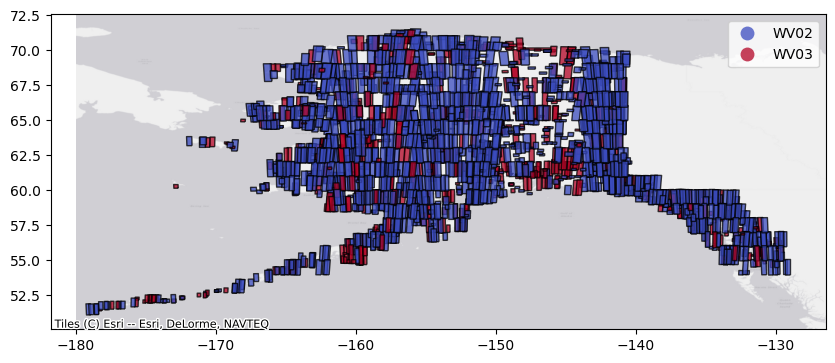

In [48]:
# Prefer to join VHR df to my footprints
footprints_vhr_meta_Alaska_ahri_20221004_gdf = pd.merge(footprint_gdf_toa, vhr_meta_Alaska_ahri_20221004_df[['id', 'el', 'az', 'sunel', 'sunaz']], how='left', left_on = 'catid', right_on = 'id', copy=False)
MAP_FOOTPRINTS(footprints_vhr_meta_Alaska_ahri_20221004_gdf, 'sensor')

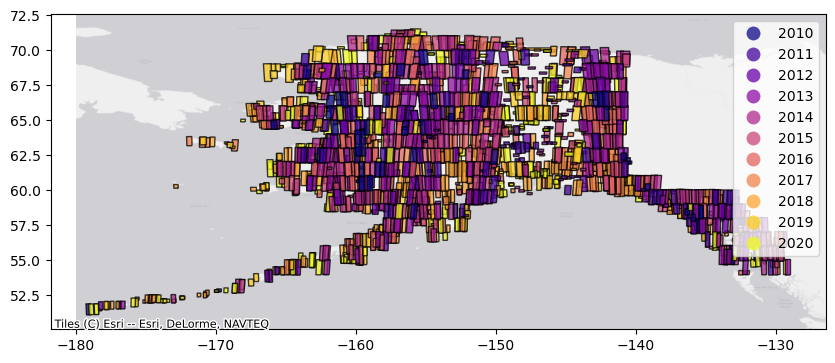

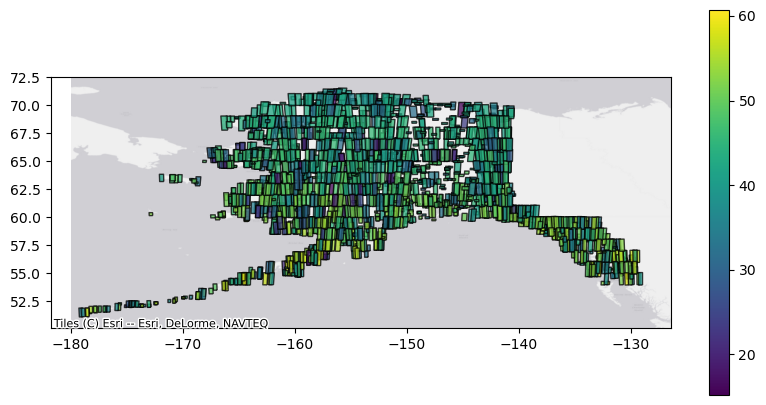

In [49]:
MAP_FOOTPRINTS(footprints_vhr_meta_Alaska_ahri_20221004_gdf, 'year', CMAP='plasma')
MAP_FOOTPRINTS(footprints_vhr_meta_Alaska_ahri_20221004_gdf, 'sunel', CAT=False, CMAP='viridis')

## Save TOA footprints for CCDC creation

In [50]:
footprints_vhr_meta_Alaska_ahri_20221004_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2190 entries, 0 to 2189
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   geometry        2190 non-null   geometry
 1   footprint_name  0 non-null      object  
 2   path            2190 non-null   object  
 3   file            2190 non-null   object  
 4   area_km2        2190 non-null   float64 
 5   area_ha         2190 non-null   float64 
 6   type            2190 non-null   object  
 7   name            2190 non-null   object  
 8   catid           2190 non-null   object  
 9   sensor          2190 non-null   object  
 10  year            2190 non-null   int64   
 11  month           2190 non-null   int64   
 12  id              2190 non-null   object  
 13  el              2190 non-null   float64 
 14  az              2190 non-null   float64 
 15  sunel           2190 non-null   float64 
 16  sunaz           2190 non-null   float64 
dtypes: flo

In [51]:
footprints_vhr_meta_Alaska_ahri_20221004_gdf.to_file('/explore/nobackup/people/pmontesa/srlite/footprints_vhrmeta_toa_Alaska_ahri_20221004.gpkg', driver='GPKG')

In [5]:
footprints_gdf_ahri_20220818_adapt = gpd.read_file('/explore/nobackup/people/mmacande/footprints/ahri_scenes_in_adapt_20220818.gpkg')
footprints_gdf_ahri_20220818_adapt.info()
MAP_FOOTPRINTS(footprints_gdf_ahri_20220818_adapt, 'FIRST_sensor')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3305 entries, 0 to 3304
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   catalog_id       3305 non-null   object  
 1   FIRST_acq_date   3305 non-null   object  
 2   FIRST_sensor     3305 non-null   object  
 3   MEAN_off_nadir   3305 non-null   float64 
 4   MEAN_sun_elev    3305 non-null   float64 
 5   MEAN_cloudcover  3305 non-null   float64 
 6   MEAN_accuracy    3305 non-null   float64 
 7   FIRST_year       3305 non-null   int64   
 8   FIRST_month      3305 non-null   object  
 9   FIRST_mm         3305 non-null   object  
 10  Shape_Length     3305 non-null   float64 
 11  Shape_Area       3305 non-null   float64 
 12  geometry         3305 non-null   geometry
dtypes: float64(6), geometry(1), int64(1), object(5)
memory usage: 335.8+ KB


### Filter out WV02,WV03 from above to isolate GE01 and QB02 - submit for SRLite processing

In [6]:
footprints_gdf_ahri_20220818_adapt[
                                                        (footprints_gdf_ahri_20220818_adapt.FIRST_sensor == 'WV02') | 
                                                        (footprints_gdf_ahri_20220818_adapt.FIRST_sensor == 'WV03')
                                                ].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2572 entries, 135 to 2706
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   catalog_id       2572 non-null   object  
 1   FIRST_acq_date   2572 non-null   object  
 2   FIRST_sensor     2572 non-null   object  
 3   MEAN_off_nadir   2572 non-null   float64 
 4   MEAN_sun_elev    2572 non-null   float64 
 5   MEAN_cloudcover  2572 non-null   float64 
 6   MEAN_accuracy    2572 non-null   float64 
 7   FIRST_year       2572 non-null   int64   
 8   FIRST_month      2572 non-null   object  
 9   FIRST_mm         2572 non-null   object  
 10  Shape_Length     2572 non-null   float64 
 11  Shape_Area       2572 non-null   float64 
 12  geometry         2572 non-null   geometry
dtypes: float64(6), geometry(1), int64(1), object(5)
memory usage: 281.3+ KB


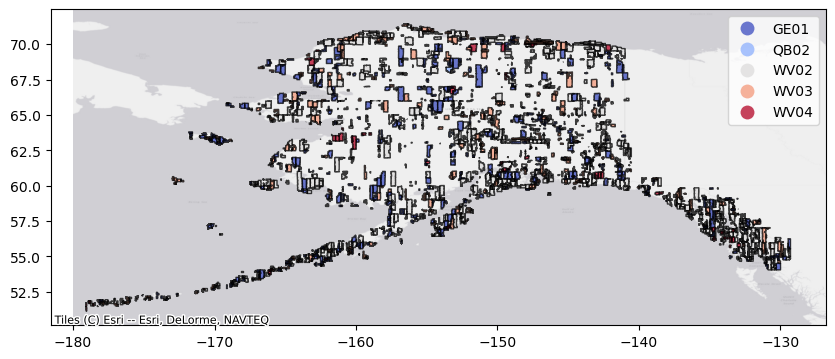

In [30]:
footprints_gdf_ahri_20220818_not_adapt = gpd.read_file('/explore/nobackup/people/mmacande/footprints/ahri_scenes_not_in_adapt_20220818.gpkg')
MAP_FOOTPRINTS(footprints_gdf_ahri_20220818_not_adapt, 'FIRST_sensor')